# Prédiction de départ clients (Churn Prediction)

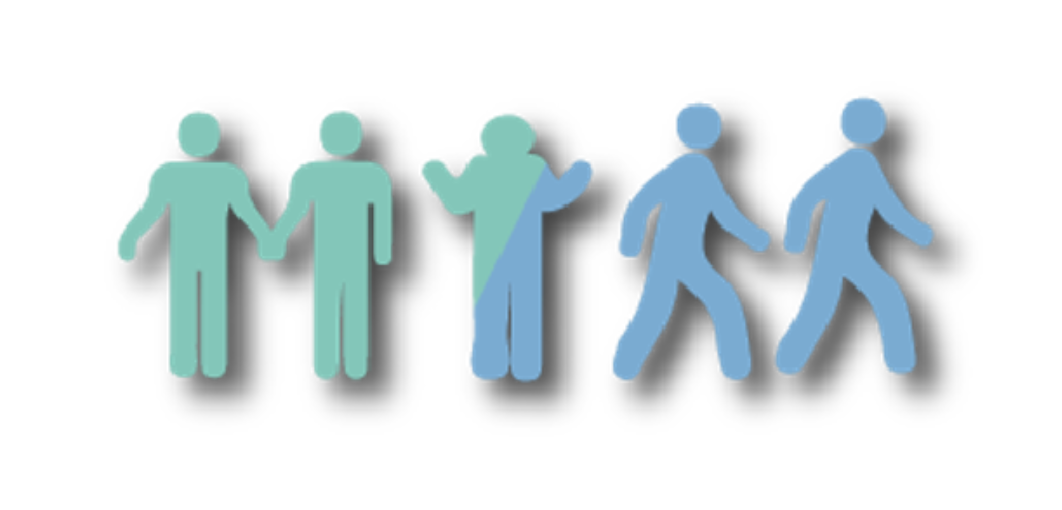

## *Saviez-vous qu'attirer d'un nouveau client coûte cinq fois plus cher que la fidélisation d'un client existant ?*

# Sommaire

- 1. Introduction
- 2. Chargement et nettoyage des données
- 3. Manipulation des données
- 4. Modélisation
- 5. Conclusion

# 1. Introduction

Qu’est-ce que l’attrition client (que l'on va nommer 'Churn' tout au long du projet) ?

Le churn désigne la perte de clients ou d’abonnés, c’est-à-dire lorsqu’ils cessent de faire appel aux services ou produits d’une entreprise.

Dans le secteur des télécommunications, les consommateurs ont un large choix de fournisseurs et peuvent facilement passer de l’un à l’autre. Cette grande liberté de mouvement complexifie les efforts de fidélisation, notamment parce que la majorité des entreprises opèrent à grande échelle, rendant difficile un accompagnement individualisé de chaque client. Une telle approche serait trop coûteuse par rapport aux bénéfices potentiels.

Cependant, si une entreprise est en mesure d’anticiper les départs potentiels, elle peut concentrer ses efforts de fidélisation sur les clients les plus à risque. Cette approche ciblée permet de maximiser l’impact des actions de rétention, tout en optimisant les coûts. Dans ce contexte, la fidélisation devient un levier stratégique essentiel pour élargir sa base client et renforcer sa position concurrentielle. Plus une entreprise parvient à retenir ses clients, plus elle augmente sa rentabilité et réduit ses coûts d’acquisition.

Le taux d’attrition est donc un indicateur clé de performance. Il est en effet bien plus rentable de conserver un client existant que d’en conquérir un nouveau.

Pour réduire ce taux, les entreprises doivent être capables d’identifier les signaux faibles annonciateurs d’un départ. Cela nécessite une vision 360° du client, intégrant ses interactions sur l’ensemble des canaux : visites en boutique, historique d’achats, appels au service client, navigation en ligne, activité sur les réseaux sociaux, etc.

En s’attaquant de manière proactive à l’attrition, les entreprises peuvent non seulement limiter leurs pertes, mais aussi renforcer durablement leur croissance. Plus leur base client est solide, plus leur modèle économique devient performant. Ainsi, anticiper les départs et mettre en place une stratégie de fidélisation efficace devient un enjeu central pour assurer leur pérennité.

# 2. Chargement et nettoyage des données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

In [ ]:
df.drop_duplicates(inplace=True)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Check de valeurs manquantes
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


*11 valeurs manquantes dans la colonne TotalCharges.*

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
df = df.reset_index(drop=True)

# 3. Manipulation des données

In [ ]:
df['Churn'].value_counts(normalize=True)

,proportion
Churn,
No,0.734215
Yes,0.265785


In [17]:
g_labels = ['Homme', 'Femme']
c_labels = ['Non', 'Oui']


fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=df['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn'].value_counts(), name="Churn"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.3, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Répartition du genre et des churn",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Genre', x=0.195, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.805, y=0.5, font_size=20, showarrow=False)])
fig.show()

*26,6 % des clients ont changé de marque.
Les clients sont à 49,5 % des femmes et à 50,5 % des hommes.*

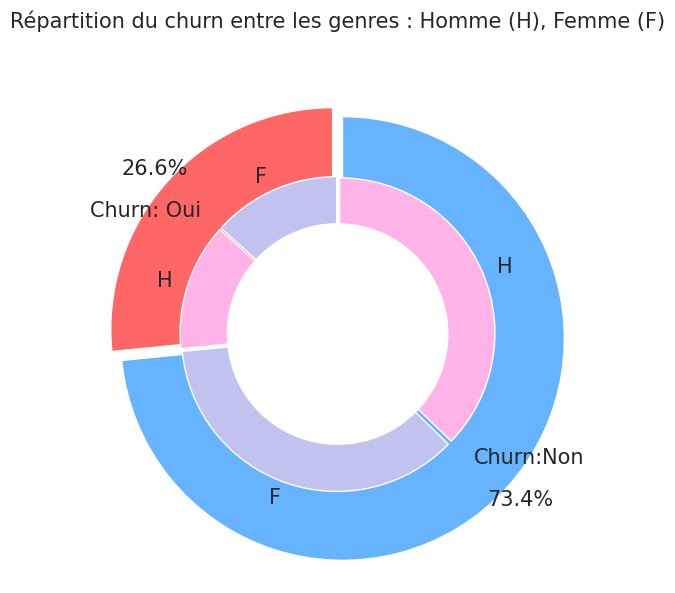

In [ ]:
plt.figure(figsize=(6, 6))
labels =["Churn: Oui","Churn:Non"]
values = [1869,5163]
labels_gender = ["F","H","F","H"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}

#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )


centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Répartition du churn entre les genres : Homme (H), Femme (F)', fontsize=15, y=1.1)



plt.axis('equal')
plt.tight_layout()
plt.show()

On remarque une influence négligeable du genre sur la propension à churn ou non.

In [19]:
# Données pie 1 : distribution brute
labels_1 = df['PaymentMethod'].value_counts().index
values_1 = df['PaymentMethod'].value_counts().values

# Données pie 2 : churn ratio par méthode
churn_rate = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack().fillna(0)
labels_2 = churn_rate.index
values_2 = churn_rate['Yes']  # Taux de churn (exprimé en %)

# Création des 2 pie charts côte à côte
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels_1, values=values_1, name="Répartition", hole=0.3), 1, 1)
fig.add_trace(go.Pie(labels=labels_2, values=values_2, name="Taux de churn", hole=0.3), 1, 2)

# Titres
fig.update_layout(
    title_text="<b>Analyse de la méthode de paiement</b>",
    annotations=[
        dict(text='Répartition', x=0.19, y=0.5, font_size=13, showarrow=False),
        dict(text='Taux de churn', x=0.823, y=0.5, font_size=13, showarrow=False)
    ]
)

fig.show()

#### *On remarque un taux de churn plus élevé chez les personnes réglant en chèque électronique.*

In [26]:
color_map = {
    'Yes': '#ff6666',
    'No': '#66b3ff'
}

fig = px.histogram(
    df,
    x="Churn",
    color="Contract",
    barmode="group",
    title="<b>Répartition des contrats client<b>",
    color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

#### *Les personnes ayant un contrat mensuel ont tendance à churn plus souvent.*

In [27]:

df['InternetService_label'] = df['InternetService'].replace({
    'Fiber optic': 'Fibre optique',
    'DSL': 'DSL',
    'No': 'Pas d\'internet',
})

color_map = {
    'Yes': '#ff6666',
    'No': '#66b3ff'
}

#MODIFIER TITRE LEGENDE

fig = px.histogram(
    df,
    x="Churn",
    color="InternetService_label",
    barmode="group",
    title="<b>Répartition des services internet<b>",
    color_discrete_map=color_map)
fig.update_layout(
    width=700,
    height=500,
    bargap=0.1,
    legend_title_text="")
fig.show()

#### *De nombreux clients choisissent le service de fibre optique et il est intéressant de noter que ceux choisissant ce service ont un taux de désabonnement très élevé, cela suggère une insatisfaction autour de ce service : un prix trop élevé ? qualité ? saturation ?*
*Les clients qui bénéficient du service DSL sont majoritaires et ont un taux de désabonnement inférieur à celui du service de fibre optique.*

In [24]:
color_map = {
    'Yes': '#ff6666',
    'No': '#66b3ff'
}

fig = px.histogram(
    df,
    x="Churn",
    color="Partner",
    barmode="group",
    title="<b>Répartition des clients sans ou avec partenaire<b>",
    color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

#### *Les clients sans partenaires ont une propension plus élevée à churn.*

In [5]:
color_map = {
    'Yes': '#ff6666',
    'No': '#66b3ff'
}

fig = px.histogram(
    df,
    x="Churn",
     color="OnlineSecurity",
    barmode="group",
    title="<b>Répartition des clients sans ou avec une sécurité en ligne<b>",
    color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

#### *Les clients sans sécurité ont tendance à churn plus.*

In [20]:
color_map = {
    'Yes': '#ff6666',
    'No': '#66b3ff'
}

fig = px.histogram(
    df,
    x="Churn",
    color="TechSupport",
    barmode="group",
    title="<b>Répartition des clients sans ou avec support technique<b>",
    color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)

#### *Pareillement pour les clients sans support technique : une tendance à churn plus élevée est présente.*

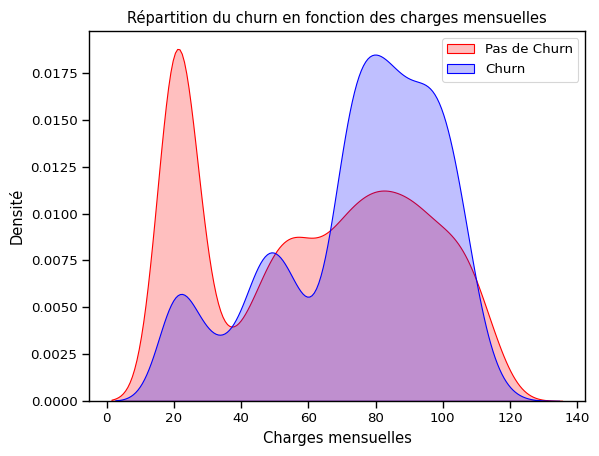

In [29]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'No') ],
                color="Red", shade = True);
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Pas de Churn","Churn"],loc='upper right');
ax.set_ylabel('Densité');
ax.set_xlabel('Charges mensuelles');
ax.set_title('Répartition du churn en fonction des charges mensuelles');

#### *Plus le prix est élevé plus les clients ont tendance à churn, ce graphique permet de visualiser ce phénomène et de le quantitifier.*

In [32]:
fig = px.box(df, x='Churn', y = 'tenure')


fig.update_yaxes(title_text='Ancienneté (Mois)', row=1, col=1)
fig.update_xaxes(title_text='Churn', row=1, col=1)


fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Ancienneté vs Churn</b>',
)

fig.show()

# 4. Modélisation

Dans cette section, nous allons entraîner un modèle de machine learning capable de prédire la probabilité qu’un client résilie son abonnement (churn). L’objectif est d’identifier les clients à risque afin d’anticiper et réduire les départs.

Nous commencerons par un modèle de régression logistique, puis testerons un modèle d’ensemble plus puissant (Random Forest).

In [4]:
# Cible
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop ID + target
X = df.drop(['customerID', 'Churn'], axis=1)

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[917 118]
 [172 202]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



**Résultats :**

- Accuracy : 80%
- F1-score pour la classe churn : 0.59

Le modèle détecte correctement une bonne partie des clients fidèles (classe 0), mais a plus de difficulté sur les churners (classe 1), avec un rappel de seulement 54%.

#### Testons le modèle RandomForest maintenant.

In [6]:
# Modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction
y_pred_rf = rf_model.predict(X_test)

# Évaluation
print(confusion_matrix(y_test, y_pred_rf))

[[947  88]
 [200 174]]


In [7]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.47      0.55       374

    accuracy                           0.80      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



**Résultats :**

- Accuracy : 80%
- F1-score pour la classe churn : 0.55
- Le rappel sur la classe churn descend à 0.47, l'ordre de grandeur est globalement similaire.

Le gain en performance est marginal ici, ce qui suggère qu’un meilleur tuning ou des variables supplémentaires pourraient être nécessaires pour aller plus loin.

In [8]:
# Définir les paramètres à tester
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Initialiser le modèle
rf_base = RandomForestClassifier(random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid,
                           scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)

# Entraînement
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Meilleurs hyperparamètres : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [9]:
# Réentraîner le modèle Random Forest avec les meilleurs hyperparamètres
best_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42
)

best_rf_model.fit(X_train, y_train)

# Prédictions
y_pred_best = best_rf_model.predict(X_test)

# Évaluation
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

[[954  81]
 [200 174]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.68      0.47      0.55       374

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



**Résultats après optimisation :**

- Accuracy : 80%
- F1-score classe churn : 0.55
- Meilleurs hyperparamètres : (tu peux les afficher ici)

Malgré l’optimisation, le modèle reste limité dans sa capacité à capturer les churners. Cela ouvre des pistes d’amélioration possibles.

### Importance des variables

Visualisons maintenant les 15 variables les plus importantes pour le modèle final. Cela nous aidera à comprendre les facteurs clés associés à la résiliation des clients.

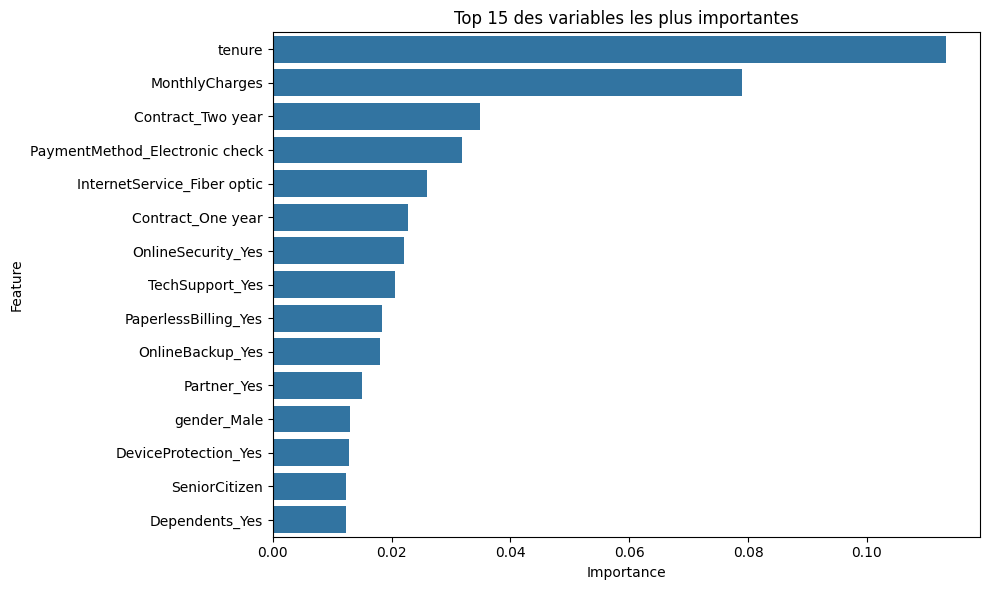

In [10]:
importances = best_rf_model.feature_importances_
features = X_encoded.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage des 15 variables les plus importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title("Top 15 des variables les plus importantes")
plt.tight_layout()
plt.show()

**Variables influentes :**

- `tenure` (ancienneté) est de loin la variable la plus importante.
- Suivent `MonthlyCharges`, `Contract_Two year`, ou encore le type de paiement.
- Certains services comme `OnlineSecurity`, `TechSupport` ou `InternetService` influencent aussi fortement la probabilité de churn.

Ces insights permettent d’orienter des actions marketing ciblées.

# 5. Conclusion

Dans ce projet, nous avons mené une **analyse complète du churn client** pour une entreprise de télécommunications. L’objectif était d’identifier les principaux facteurs influençant le départ des clients, puis de construire un **modèle prédictif** permettant d’anticiper ces départs.

### Ce que nous avons appris
- Les clients les plus susceptibles de partir sont souvent ceux :
  - Sous **contrat mensuel**
  - Sans **sécurité en ligne** ou **support technique**
  - Utilisant la **fibre optique**
  - Payant par **prélèvement électronique**
- La variable la plus déterminante est la **durée d’ancienneté (`tenure`)**, suivie des **charges mensuelles**.

**Des décisions marketing stratégiques peuvent être prises à partir de ces insights.**

---

*Ce projet est un exemple de mission complète.*